In [1]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=154089f2741b60936e0037f71bbd3557ed7ced98cadb3e18c2f8e095b7da7453
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [0]:
import utils
from get_dataset import get_dataset
import random
import time
import torch
import torch.nn as nn
from torch.optim import Adam
from torchtext.data import Iterator
from importlib import reload

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
dataset, emb_weights = get_dataset()

random.seed(43)
ds_train, ds_val, ds_test = dataset.split(split_ratio=[0.8, 0.1, 0.1], random_state=random.getstate())

.vector_cache/glove.6B.zip: 862MB [06:31, 2.20MB/s]                           
100%|█████████▉| 399378/400000 [00:37<00:00, 11059.75it/s]

In [0]:
class Baseline_model(nn.Module):
  """
  """
  def __init__(self, vocab_size, embed_dim, embed_vecs=None):
    super().__init__()
    self.embedding = nn.EmbeddingBag(vocab_size, embed_dim)
    if embed_vecs is not None:
      self.embedding = nn.EmbeddingBag.from_pretrained(embed_vecs)
    else:
      self.embedding = nn.EmbeddingBag(vocab_size, embed_dim)
    self.fc1 = nn.Linear(embed_dim, embed_dim//2)
    self.fc2 = nn.Linear(embed_dim//2, 2)
    self.relu = nn.ReLU()

  def forward(self, x):
    out = self.embedding(x)
    out = self.relu(self.fc1(out))
    return self.fc2(out)

In [0]:
def learner(model, loss_fn, optimiser, epochs=1, device=device):
  start_time = time.time()
  for epoch in range(epochs):
    
    total_loss = 0
    for i, batch in enumerate(Iterator(ds_train, 1, shuffle=True, device=device), 1):
      optimiser.zero_grad()

      output = model(batch.review)
      loss = loss_fn(output, batch.label)
      total_loss += loss.item()

      loss.backward()
      optimiser.step()

      if not i % (len(ds_train)//3):
        avg_loss = total_loss / (len(ds_train)//3)
        val_loss, val_accuracy = utils.validate(ds_val, loss_fn, model)
        print('Epoch : {}, batch : {}, train_loss = {:.4f}, val_loss = {:.4f}, val_accuracy : {:.3f}, time = {:.0f}s'.format(
            epoch + 1, i, avg_loss, val_loss, val_accuracy, time.time() - start_time))
        total_loss = 0

In [0]:
vocab_size = len(emb_weights)
embed_size = 300

model = Baseline_model(vocab_size, embed_size, emb_weights).to(device)
loss_fn = nn.CrossEntropyLoss().to(device)
optimiser = Adam(model.parameters())

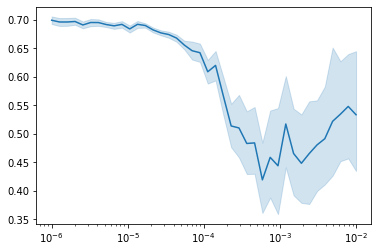

In [8]:
utils.lr_finder(model, ds_train, optimiser, loss_fn, lr_range=[1e-6, 1e-2])

In [9]:
optimiser = Adam(model.parameters(), lr=2e-4)
learner(model, loss_fn, optimiser, epochs=10)

Epoch : 1, batch : 800, train_loss = 0.6426, val_loss = 0.5838, val_accuracy : 0.743, time = 1s
Epoch : 1, batch : 1600, train_loss = 0.5003, val_loss = 0.4876, val_accuracy : 0.793, time = 2s
Epoch : 1, batch : 2400, train_loss = 0.4689, val_loss = 0.4582, val_accuracy : 0.770, time = 4s
Epoch : 2, batch : 800, train_loss = 0.4319, val_loss = 0.4457, val_accuracy : 0.770, time = 5s
Epoch : 2, batch : 1600, train_loss = 0.3809, val_loss = 0.4302, val_accuracy : 0.817, time = 6s
Epoch : 2, batch : 2400, train_loss = 0.4172, val_loss = 0.4204, val_accuracy : 0.800, time = 7s
Epoch : 3, batch : 800, train_loss = 0.3902, val_loss = 0.4275, val_accuracy : 0.790, time = 8s
Epoch : 3, batch : 1600, train_loss = 0.3515, val_loss = 0.4190, val_accuracy : 0.823, time = 10s
Epoch : 3, batch : 2400, train_loss = 0.3979, val_loss = 0.4103, val_accuracy : 0.807, time = 11s
Epoch : 4, batch : 800, train_loss = 0.3719, val_loss = 0.4226, val_accuracy : 0.803, time = 12s
Epoch : 4, batch : 1600, train_

In [0]:
torch.save(model.state_dict(), 'data/model_baseline.pt')

In [11]:
model.embedding.weight.requires_grad_(True);
optimiser = Adam(model.parameters(), lr=1e-4)
learner(model, loss_fn, optimiser, epochs=5)

Epoch : 1, batch : 800, train_loss = 0.3054, val_loss = 0.4078, val_accuracy : 0.813, time = 42s
Epoch : 1, batch : 1600, train_loss = 0.2565, val_loss = 0.3884, val_accuracy : 0.843, time = 84s
Epoch : 1, batch : 2400, train_loss = 0.3058, val_loss = 0.3708, val_accuracy : 0.850, time = 127s
Epoch : 2, batch : 800, train_loss = 0.2594, val_loss = 0.3795, val_accuracy : 0.840, time = 169s
Epoch : 2, batch : 1600, train_loss = 0.2016, val_loss = 0.3696, val_accuracy : 0.853, time = 211s
Epoch : 2, batch : 2400, train_loss = 0.2520, val_loss = 0.3553, val_accuracy : 0.877, time = 253s
Epoch : 3, batch : 800, train_loss = 0.2158, val_loss = 0.3641, val_accuracy : 0.850, time = 295s
Epoch : 3, batch : 1600, train_loss = 0.1594, val_loss = 0.3595, val_accuracy : 0.873, time = 337s
Epoch : 3, batch : 2400, train_loss = 0.2063, val_loss = 0.3465, val_accuracy : 0.883, time = 379s
Epoch : 4, batch : 800, train_loss = 0.1782, val_loss = 0.3566, val_accuracy : 0.863, time = 421s
Epoch : 4, batch

In [0]:
torch.save(model.state_dict(), 'data/model_baseline_fine.pt')

In [13]:
print('Test loss : {:.5f}, test accuracy : {:.03f}'.format(*utils.validate(ds_test, loss_fn, model)))

Test loss : 0.32218, test accuracy : 0.863
